In [50]:
import pandas
import math

In [52]:
df = pandas.read_csv('company_directorships.csv')
# — NEW: uppercase director names so they match the aggregation table —
df['director_name'] = df['director_name'].str.upper()
df['software_background'] = df['software_background'] == 't'
df.sample(5)


,company_name,cikcode,director_name,software_background,start_date,end_date
9738,PUBLIC SERVICE CO OF NEW MEXICO,81023,ROBERT M. PRICE,True,2001-05-24,2001-05-24
11498,TELEFLEX INC,96943,NEENA M. PATIL,False,2022-03-30,2025-03-28
5818,Horizon Kinetics Holding Corp,88000,PHILIP NERI,False,2012-04-06,2012-04-06
5573,HAVERTY FURNITURE COMPANIES INC,216085,AL TRUJILLO,False,2013-03-28,2025-03-28
9382,PARSONS CORP,275880,STEVEN F. LEER,True,2020-03-10,2025-03-05


In [54]:
compensation_and_demographics_raw = pandas.read_csv('director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None
    
compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [55]:
compensation_and_demographics.gender.value_counts(dropna=False)

gender
male       3850
female     1550
None         19
unknown       2
Name: count, dtype: int64

In [58]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

director_name
A CHARLENE SULLIVAN, PH.D.     1
MICHAEL L. KUTA                1
MICHAEL L. LARUSSO             1
MICHAEL L. MILLER              1
MICHAEL L. OWENS               1
                              ..
MARTIN L. FLANAGAN            13
ANN BARNETT STERN             13
TERESA M. RESSEL              13
BRUCE L. CROCKETT             13
ALBERT R. DOWDEN              14
Name: company_name, Length: 11827, dtype: int64

/var/folders/9v/c0m4f54j51s_f25xxf99vz8r0000gn/T/ipykernel_26888/1965995127.py:20: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


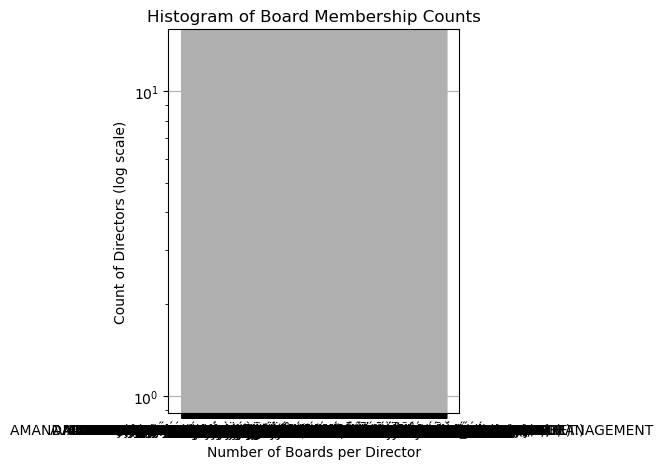

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load the directorship CSV into a DataFrame:
directorships_df = pd.read_csv('company_directorships.csv')

# 2) Count how many boards each director sits on:
directorship_counts = directorships_df['director_name'] \
    .value_counts() \
    .sort_index()

# 3) Plot the histogram as a bar chart with a log y-axis:
plt.figure()
plt.bar(directorship_counts.index, directorship_counts)
plt.yscale('log')
plt.xlabel('Number of Boards per Director')
plt.ylabel('Count of Directors (log scale)')
plt.title('Histogram of Board Membership Counts')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [62]:
people = set()
companies = set()
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.add(director_name)
    companies.add(company_name)


In [63]:
# : find the component with maximum size, not just the first 
largest_cc = max(networkx.connected_components(graph), key=len)
biggest_connected_graph = graph.subgraph(largest_cc)


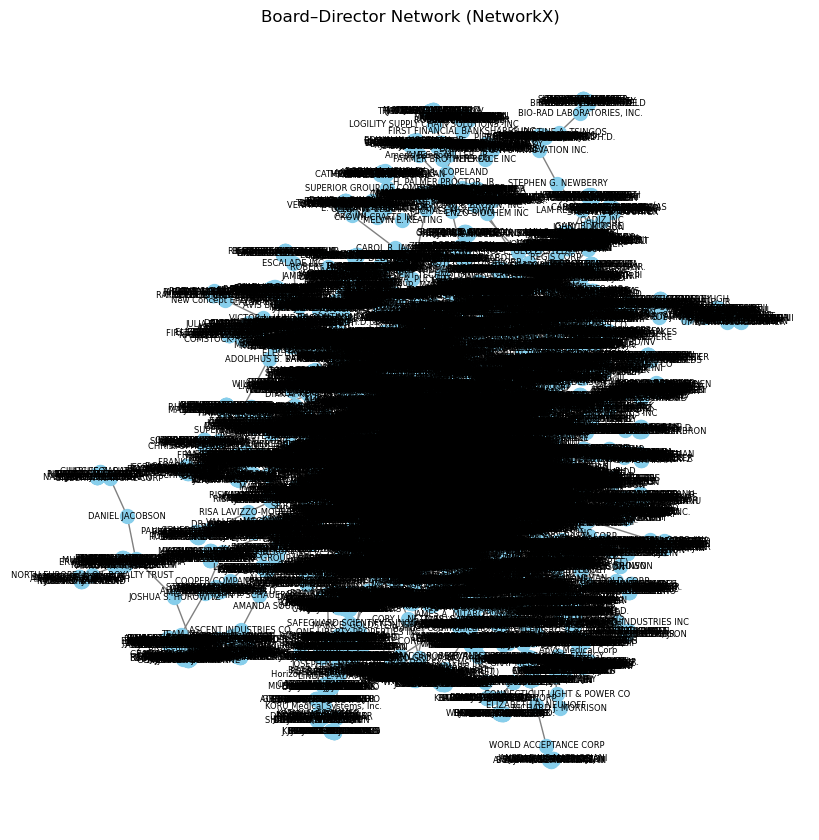

In [64]:
import matplotlib.pyplot as plt
import networkx as nx

# If you already ran the cell that created `subG`, skip these two lines.
# Otherwise, rebuild the largest‐component subgraph here:
# (Assumes G is your full bipartite graph of companies+directors)
largest_cc = max(nx.connected_components(G), key=len)
biggest_connected_graph = G.subgraph(largest_cc)

# Now plot with NetworkX.draw
pos = nx.spring_layout(biggest_connected_graph, seed=42)

plt.figure(figsize=(8,8))
nx.draw(
    biggest_connected_graph,
    pos,
    with_labels=True,
    node_size=100,
    node_color='skyblue',
    edge_color='gray',
    font_size=6
)
plt.title('Board–Director Network (NetworkX)')
plt.axis('off')
plt.show()



In [65]:
%%time
import networkx as nx

centrality = pandas.DataFrame({
    'eigen':       pandas.Series(nx.eigenvector_centrality(biggest_connected_graph)),
    'degree':      pandas.Series(nx.algorithms.degree_centrality(biggest_connected_graph)),
    'betweenness': pandas.Series(nx.betweenness_centrality(biggest_connected_graph)),
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)


CPU times: user 2min 48s, sys: 676 ms, total: 2min 49s
Wall time: 2min 50s


In [66]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [67]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,betweenness,is_person,age,compensation,gender,log_compensation
ELIZABETH KRENTZMAN,1.024389e-01,0.001585,1.394057e-07,True,65,3408245,female,6.532531
CAROL DECKBAR,1.024389e-01,0.001585,1.394057e-07,True,62,43263,female,4.636127
ELI JONES,1.024389e-01,0.001585,1.394057e-07,True,63,3063255,male,6.486183
DOUGLAS SHARP,1.024389e-01,0.001585,1.394057e-07,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,1.394057e-07,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...,...
JOHN J. GEBBIA,8.400282e-35,0.000122,0.000000e+00,True,86,120000,male,5.079185
ANDREW S. BORODACH,8.342633e-35,0.000122,0.000000e+00,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,0.000000e+00,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,0.000000e+00,True,70,50356,female,4.702060


In [68]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [69]:
import sklearn.cluster

In [70]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(
    people_df[['age', 'log_compensation', 'degree', 'eigen', 'betweenness']]
)


In [71]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

cluster_id
 1    3117
 0     385
 2     109
-1      72
 3      24
 4      19
 7       8
 6       5
 5       3
Name: count, dtype: int64

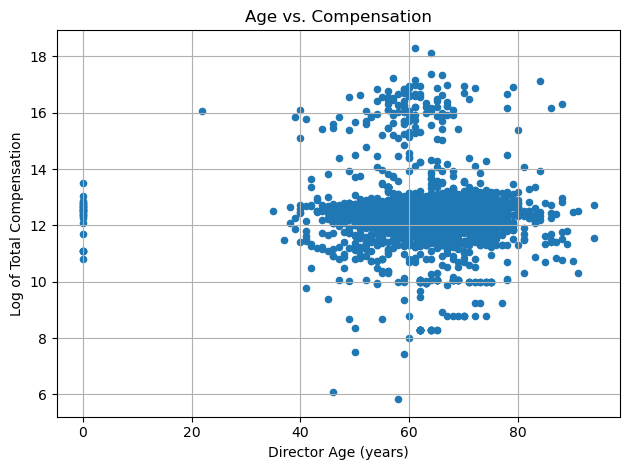

In [72]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load data
directorships_df = pd.read_csv('company_directorships.csv')
details_df        = pd.read_csv('director-details.csv')

# Rename and uppercase the name field in details_df, and compensation
details_df = details_df.rename(columns={
    'name': 'director_name',
    'compensation': 'total_compensation'
})
details_df['director_name'] = details_df['director_name'].str.upper()

# Uppercase director names in the directorships table to match
directorships_df['director_name'] = directorships_df['director_name'].str.upper()

# Build bipartite graph
G = nx.Graph()
for comp, director in zip(directorships_df['company_name'], directorships_df['director_name']):
    G.add_edge(comp, director)

# Extract largest connected component
largest_cc = max(nx.connected_components(G), key=len)
subG = G.subgraph(largest_cc)

# Compute centrality measures
centrality = pd.DataFrame({
    'eigen':       pd.Series(nx.eigenvector_centrality(subG)),
    'degree':      pd.Series(nx.degree_centrality(subG)),
    'betweenness': pd.Series(nx.betweenness_centrality(subG)),
})
people_set = set(directorships_df['director_name'])
centrality['is_person'] = centrality.index.map(lambda x: x in people_set)

# Build people_df and merge demographics
people_df = centrality[centrality['is_person']].reset_index().rename(columns={'index':'director_name'})
people_df = people_df.merge(
    details_df[['director_name','age','total_compensation']],
    on='director_name', how='left'
)
people_df['log_compensation'] = np.log(people_df['total_compensation'].replace(0, np.nan))

# Plot scatter
plt.figure()
plt.scatter(
    people_df['age'],
    people_df['log_compensation'],
    s=20
)
plt.xlabel('Director Age (years)')
plt.ylabel('Log of Total Compensation')
plt.title('Age vs. Compensation')
plt.grid(True)
plt.tight_layout()
plt.show()




In [76]:
people_df.loc['ELIZABETH KRENTZMAN']

KeyError: 'ELIZABETH KRENTZMAN'